In [2]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [3]:
credits = pd.read_csv(r'C:\Users\P059129\Documents\PrimeiroTeste\Data\credits.csv')
keywords = pd.read_csv(r'C:\Users\P059129\Documents\PrimeiroTeste\Data\keywords.csv')
movies = pd.read_csv(r'C:\Users\P059129\Documents\PrimeiroTeste\Data\movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [4]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [5]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [6]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

(0.0, 2.0, 0.9, 1.2)

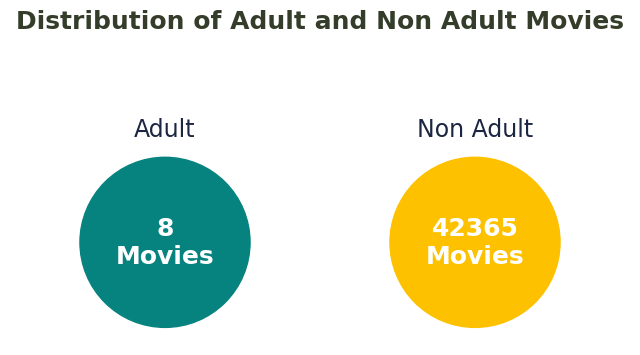

In [7]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

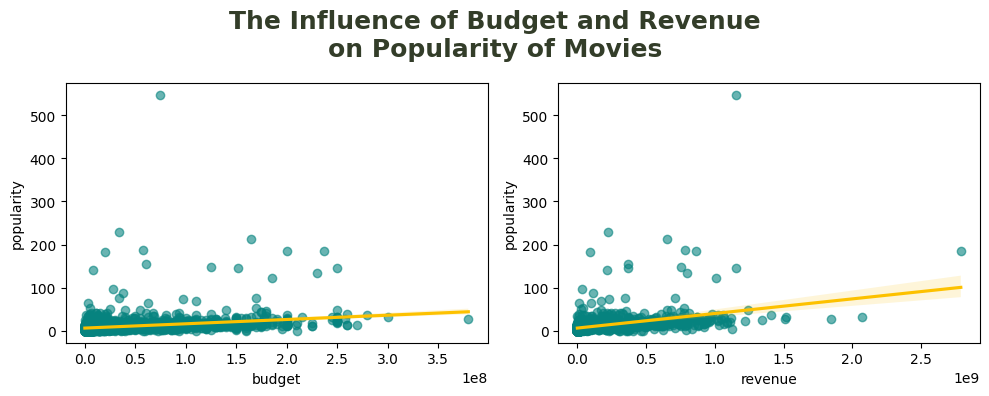

In [8]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

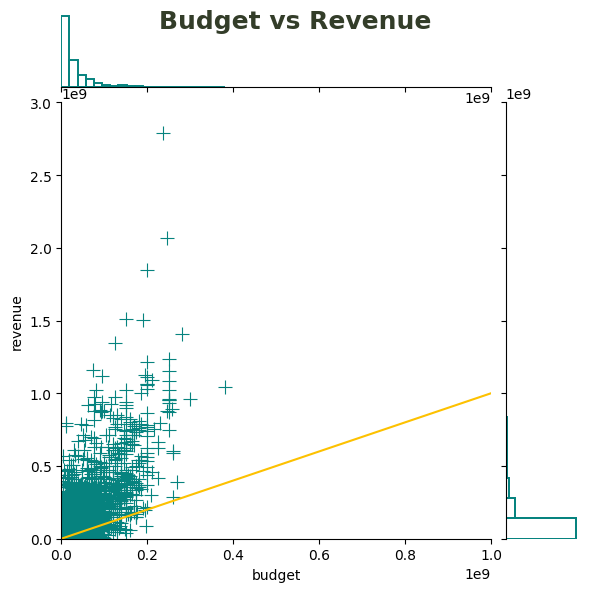

In [9]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

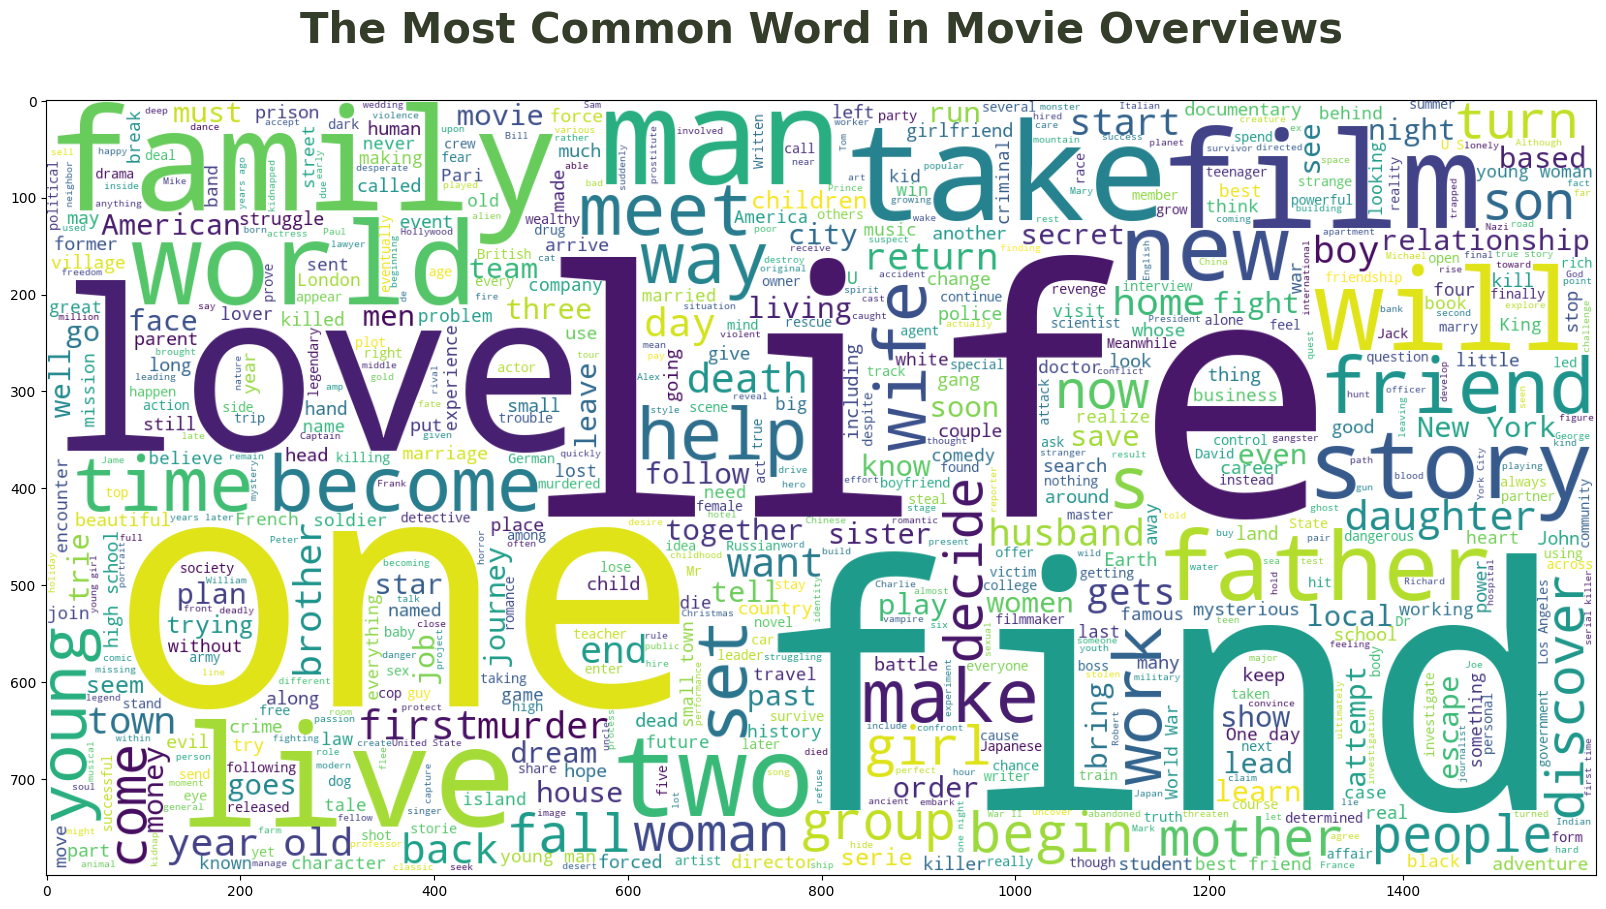

In [10]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

(-1.25, 1.25, -1.25, 1.25)

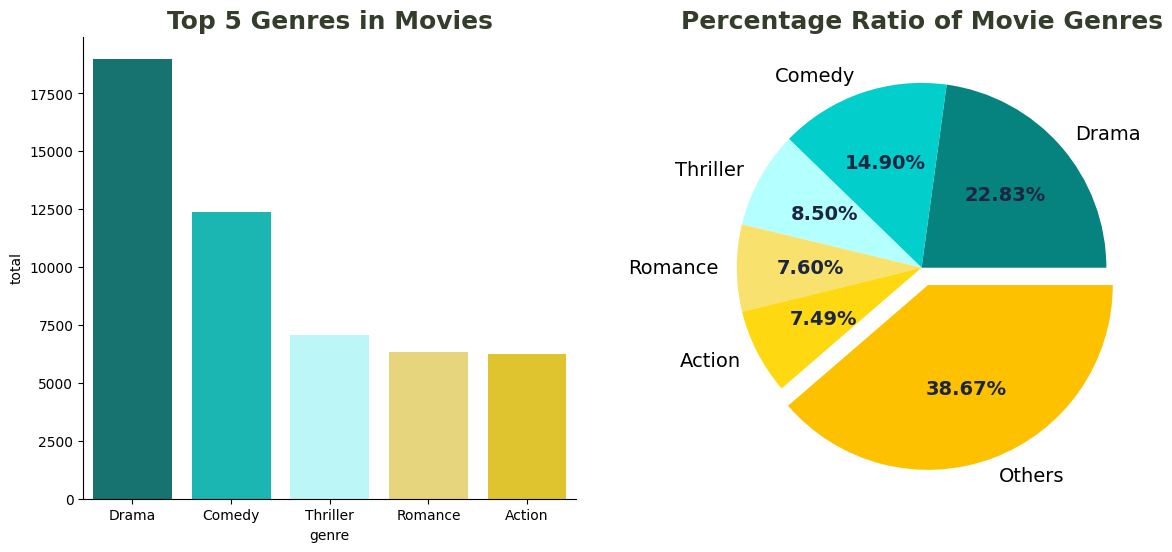

In [11]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

Text(0.5, 1.0, 'Total Released Movie by Date')

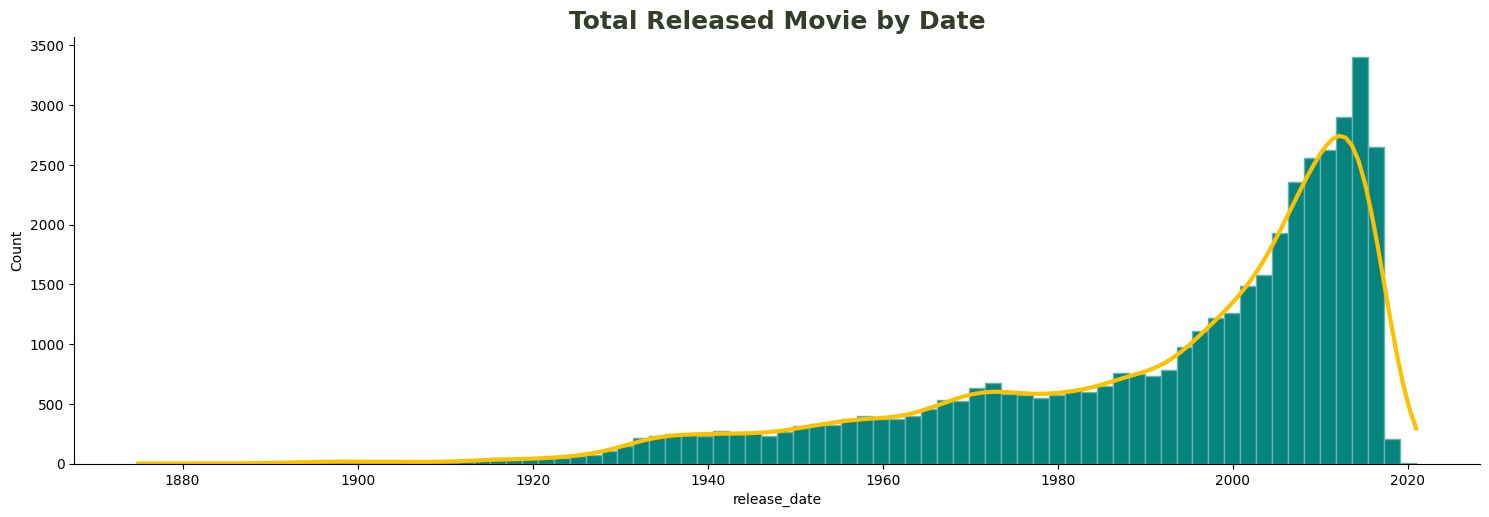

In [12]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

In [13]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))
    
spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))
        
crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))
    
country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

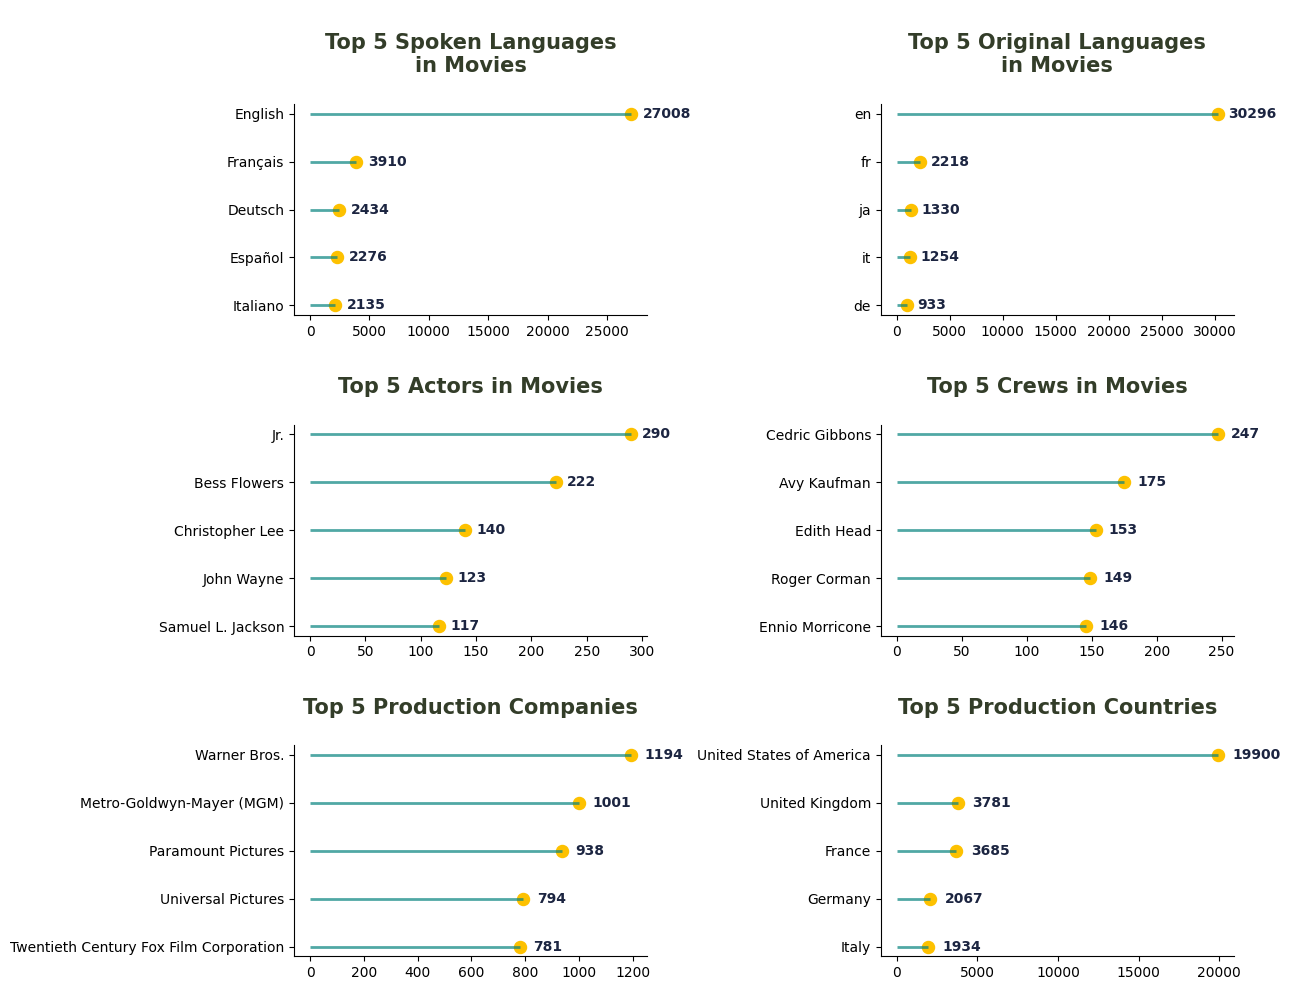

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
sns.despine()
plt.tight_layout()

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

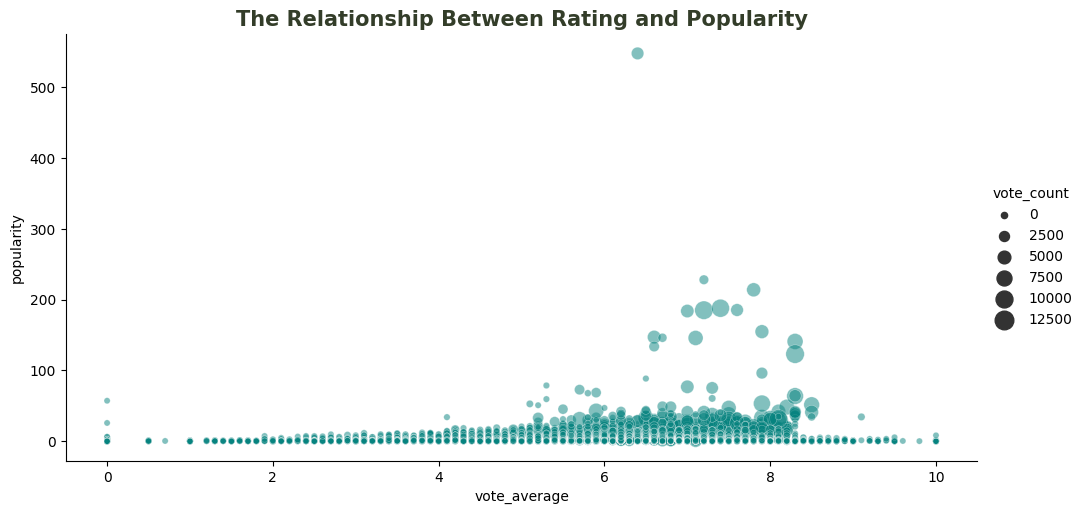

In [15]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

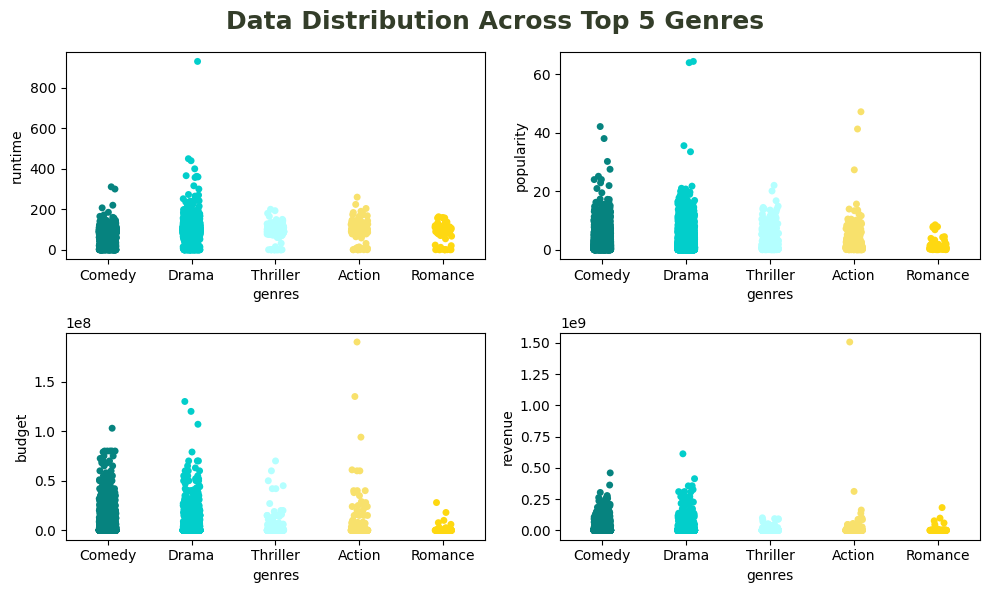

In [16]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

<Axes: title={'center': 'Correlation of Movie Features\n'}>

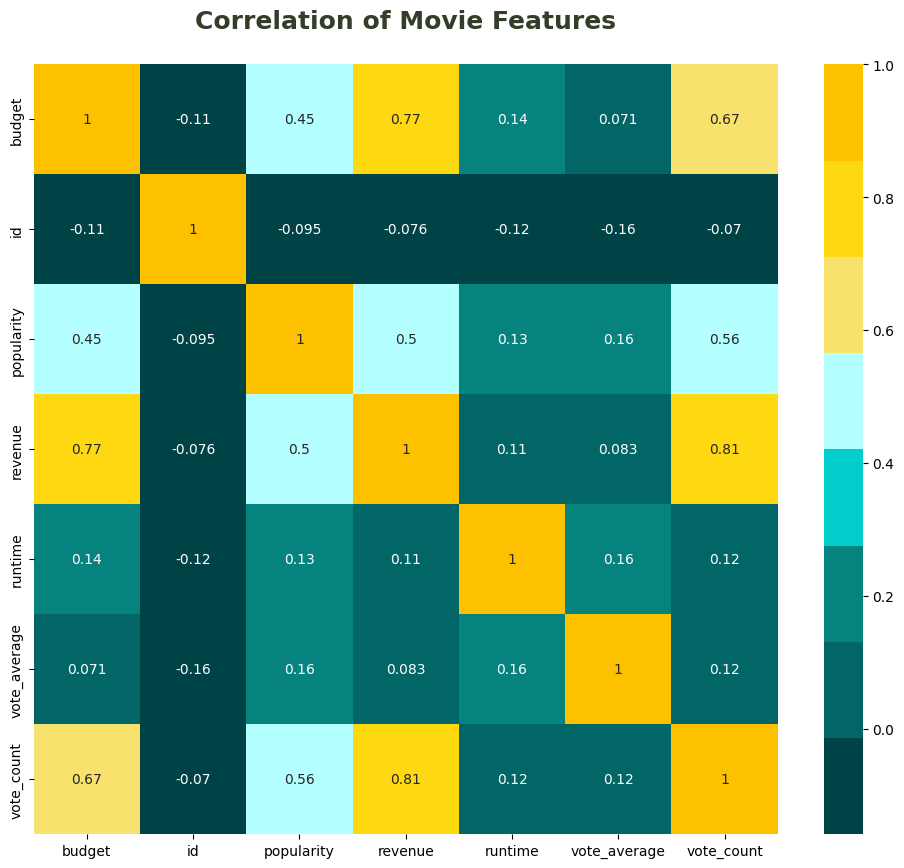

In [17]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

Sistema de recomendação híbrido.  
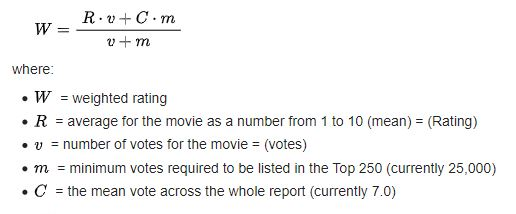

In [18]:
R = df['vote_average']
v = df['vote_count']
m = df['vote_count'].quantile(0.80)
C = df['vote_average'].mean()

df['weighted_average'] = ((R*v) + (C*m)) / (v+m)

In [19]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [20]:
weighted_df['score'] = weighted_df['weighted_average'] * 0.4 + weighted_df['popularity'].astype('float64')* 0.6 

In [21]:
weighted_df_sorted = weighted_df.sort_values('score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


In [22]:
hybrid_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [23]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t)
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text
        

In [24]:
hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
hybrid_df['overview'] = hybrid_df['overview'].apply(remove_punc)
hybrid_df['production_companies'] = hybrid_df['production_companies'].apply(separate)
hybrid_df['tagline'] = hybrid_df['tagline'].apply(remove_punc)
hybrid_df['keywords'] = hybrid_df['keywords'].apply(separate)
hybrid_df['crew'] = hybrid_df['crew'].apply(separate)
hybrid_df['characters'] = hybrid_df['characters'].apply(separate)
hybrid_df['actors'] = hybrid_df['actors'].apply(separate)

hybrid_df['bag_of_words'] = ''
hybrid_df['bag_of_words'] = hybrid_df[hybrid_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
hybrid_df.set_index('original_title', inplace=True)

hybrid_df = hybrid_df[['bag_of_words']]
hybrid_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


In [25]:
hybrid_df = weighted_df_sorted[:10000].merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(10000, 28645)

In [26]:
cos_sim = cosine_similarity(tfidf_matrix)
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending = False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [27]:
predict('Baby Driver', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Baby Driver,0.540998,1.000000,0.862300
Minions,0.841413,0.012439,0.261131
The Dark Knight,0.498630,0.065234,0.195253
Hot Fuzz,0.318704,0.129279,0.186107
John Wick,0.481297,0.045651,0.176345
Pulp Fiction,0.517827,0.025785,0.173398
The World's End,0.270193,0.129336,0.171593
Shaun of the Dead,0.326741,0.102948,0.170086
Big Hero 6,0.565386,0.000573,0.170017


DEEP LEARNING  

O TensorFlow tem uma biblioteca chamada TensorFlow Recommenders (TF-RS) que é uma biblioteca de Machine Learning para sistemas de recomendação.

In [28]:
ratings_df = pd.read_csv(r'C:\Users\P059129\Documents\PrimeiroTeste\Data\ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on = 'movieId', right_on = 'id',how='left')
ratings_df=ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 02:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 02:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 02:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 02:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 02:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [29]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [30]:
ratings_df['userId'] = ratings_df['userId'].astype('str')

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[[ 'original_title']]))

ratings = ratings.map(lambda x: 
    {
        "original_title": x["original_title"],
        "userId": x["userId"],
        "rating": x["rating"]
    })

movies=movies.map(lambda x: x["original_title"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 43188


In [32]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique users: 671


In [33]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [34]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
35/35 [==============================] - 76s 2s/step - root_mean_squared_error: 1.4717 - factorized_top_k/top_1_categorical_accuracy: 3.1429e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0080 - factorized_top_k/top_10_categorical_accuracy: 0.0186 - factorized_top_k/top_50_categorical_accuracy: 0.1034 - factorized_top_k/top_100_categorical_accuracy: 0.1723 - loss: 6812.8094 - regularization_loss: 0.0000e+00 - total_loss: 6812.8094
Epoch 2/3
35/35 [==============================] - 60s 2s/step - root_mean_squared_error: 1.0331 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0196 - factorized_top_k/top_10_categorical_accuracy: 0.0454 - factorized_top_k/top_50_categorical_accuracy: 0.2015 - factorized_top_k/top_100_categorical_accuracy: 0.3179 - loss: 6450.5723 - regularization_loss: 0.0000e+00 - total_loss: 6450.5723
Epoch 3/3
35/35 [==============================] - 59s 2s/step - root_mean_squared_error: 0.9965 - fac

In [35]:
metrics = model.evaluate(cached_test, return_dict = True)

9/9 [==============================] - 9s 989ms/step - root_mean_squared_error: 1.1705 - factorized_top_k/top_1_categorical_accuracy: 7.3278e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0049 - factorized_top_k/top_10_categorical_accuracy: 0.0099 - factorized_top_k/top_50_categorical_accuracy: 0.0479 - factorized_top_k/top_100_categorical_accuracy: 0.0865 - loss: 5726.9161 - regularization_loss: 0.0000e+00 - total_loss: 5726.9161


In [36]:
print(f"\nRetrieval top100-accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")


Retrieval top100-accuracy: 0.086.
Ranking RMSE: 1.170.


In [39]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [40]:
predict_movie(123, 5)

Top 5 recommendations for user 123:

1. The Greatest Story Ever Told
2. Un éléphant ça trompe énormément
3. Million Dollar Baby
4. Anatomie de l'enfer
5. Un long dimanche de fiançailles


In [41]:
predict_rating(123,'Minions')

Predicted rating for Minions: 2.8223721981048584


In [42]:
ratings_df[ratings_df['userId'] == '123']

,userId,movieId,rating,date,original_title,genres,overview
8053,123,233,4.0,2001-07-01 21:57:06,The Wanderers,Drama,The streets of the Bronx are owned by 60’s you...
8054,123,288,5.0,2001-07-01 20:32:47,High Noon,Western,High Noon is about a recently freed leader of ...
8055,123,407,5.0,2001-07-01 21:57:57,Kurz und schmerzlos,"Drama, Thriller",Three friends get caught in a life of major cr...
8056,123,968,3.0,2001-07-01 21:59:01,Dog Day Afternoon,"Crime, Drama, Thriller",A man robs a bank to pay for his lover's opera...
8057,123,1968,4.0,2001-07-01 20:30:36,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...
8058,123,1976,4.0,2001-07-01 20:31:51,Jezebel,"Drama, Romance","In 1850s Louisiana, the willfulness of a tempe..."
8059,123,2003,4.0,2001-07-01 20:31:51,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
8060,123,2428,5.0,2001-07-01 21:57:06,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
8061,123,2502,5.0,2001-07-01 21:59:01,The Bourne Supremacy,"Action, Drama, Thriller",When a CIA operation to purchase classified Ru...
8062,123,2762,5.0,2001-07-01 21:59:54,Young and Innocent,"Drama, Crime",Derrick De Marney finds himself in a 39 Steps ...


In [43]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

index.index_from_dataset(
    tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)


_, titles = index(tf.constant(['123']))

pred_movies = pd.DataFrame({'original_title' : [i.decode("utf-8") for i in titles[0, :5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

,original_title,genres,overview
1,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
2,Un éléphant ça trompe énormément,Comedy,Etienne falls in love with a sexy woman he mee...
3,Million Dollar Baby,Drama,Despondent over a painful estrangement from hi...
4,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
5,Un long dimanche de fiançailles,Drama,"In 1919, Mathilde was 19 years old. Two years ..."


Prever unica e exclusivamente com base em ratings e nao com base em conteudo

In [53]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()

ratings = pd.read_csv(r'C:\Users\P059129\Documents\PrimeiroTeste\Data\ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [55]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

AttributeError: 'DatasetAutoFolds' object has no attribute 'split'

In [56]:
svd = SVD()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("Average RMSE:", results['test_rmse'].mean())
print("Average MAE:", results['test_mae'].mean())

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8994  0.8933  0.8951  0.9059  0.8885  0.8965  0.0059  
MAE (testset)     0.6903  0.6905  0.6894  0.6974  0.6828  0.6901  0.0046  
Fit time          1.13    1.01    1.02    0.99    1.12    1.06    0.06    
Test time         0.15    0.13    0.36    0.15    0.17    0.19    0.09    
Average RMSE: 0.8964508433195064
Average MAE: 0.690061145063045


In [57]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [58]:
    ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [59]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.728884908943125, details={'was_impossible': False})